## What does this notebook do?
This notebook accesses data from [space-track.org](https://www.space-track.org/) to plot the distribution of active debris in LEO. The data is a part of space-track's [gp](https://www.space-track.org/documentation#api-basicSpaceDataGp) class ( general perturbations ), which is an efficient listing of the newest SGP4 keplerian element set for each artificial earth-orbiting object tracked by the 18th Space Defense Squadron.

## Requirements:
To use this notebook, replace 'username' and 'password' with your existing login credentials. Uncomment and run the required line below to ensure necessary packages are present locally/ in the cloud.

In [1]:
# %pip install matplotlib numpy pandas requests seaborn

In [2]:
import io
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
import seaborn as sns

In [3]:
username = None
password = None

if not username or not password:
    print("Enter valid credentials")

siteCred = { 'identity': username, 'password': password }

In [4]:
# Error class to handle 'POST' and 'GET' errors
class HandleError(Exception):
    def __init__(self, args):
        Exception.__init__(self, "Exception raised with args {0}".format(args))
        self.args = args

In [5]:
uriBase = "https://www.space-track.org"
requestLogin = "/ajaxauth/login"
requestQuery = "/basicspacedata/query"

# OBJECT_TYPE = DEBRIS
objectDebris = "/class/gp/OBJECT_TYPE/DEBRIS"

# Filters data by LAUNCH_DATE
predicate1  = "/LAUNCH_DATE/%3C%3Enull"

# Orders the data by NORAD_CAT_ID
orderBy = "/orderby/NORAD_CAT_ID%20asc"

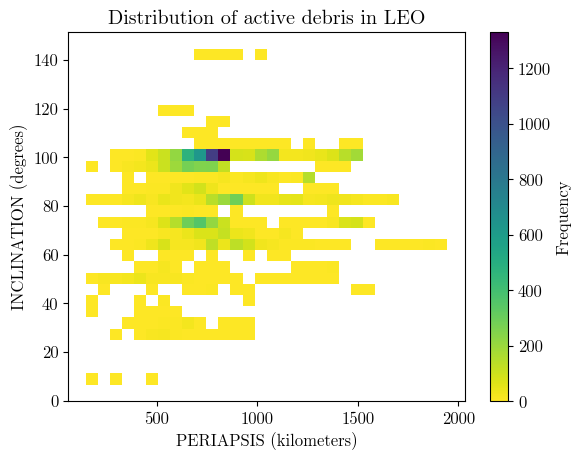

In [6]:
with requests.Session() as session:
    postCheck = session.post(uriBase + requestLogin, data = siteCred)
    if postCheck.status_code != 200:
        raise HandleError('POST')

    # Requests for DEBRIS data where LAUNCH_DATE != null
    response1 = session.get(uriBase + requestQuery + objectDebris + predicate1 + orderBy)
    if response1.status_code != 200:
        raise HandleError('GET')
    
    data1 = response1.text

    dataFrame1 = pd.read_json(io.StringIO(data1))

    """
    Using any available fonts is permissible for the plots, 
    but I chose CMU Serif for aesthetic reasons.
    For Ubuntu, you can install the font package fonts-cmu 
    (using sudo apt install fonts-cmu), which contains the fonts.
    """
    # plt.rcParams['font.family'] = "CMU Serif"
    # plt.rcParams['font.size'] = 12   

    # Drops the DEBRIS data where DECAY_DATE != null and MEAN_MOTION >= 11.25
    dataFrame1 = dataFrame1[dataFrame1['DECAY_DATE'].isnull() & (dataFrame1['MEAN_MOTION'] >= 11.25)]

    # Plots the distribution of active debris in LEO
    sns.histplot(x = 'PERIAPSIS', y = 'INCLINATION', data = dataFrame1, 
                 cmap = 'viridis_r', 
                 cbar = True, 
                 cbar_kws = {'label': 'Frequency'}, bins = 30)
    
    plt.xlabel("PERIAPSIS (kilometers)")
    plt.ylabel("INCLINATION (degrees)")
    plt.title("Distribution of active debris in LEO")

session.close()